# Data & AI: Swarm IOT

Oke dus ik ga het hier schetsen en dan kunnen jullie het verder uitwerken en zien hoe jullie het zouden structureren. Als er iets ni duidelijk is gelieve te vragen.

In [1]:
#imports
import pandas as pd
import cv2  as cv
import matplotlib.pyplot as plt
import glob
import os
import numpy as np
import tensorflow as tf
import time 

## Inlezen van csv

In [95]:
#read the csv named complete_swarmIoT_full_labeled_dataset.csv and save it in a dataframe
df = pd.read_csv('complete_swarmIoT_full_labeled_dataset.csv')
df['image'].head()

0    1666698189853.jpg
1    1666698196832.jpg
2    1666698203856.jpg
3    1666698210837.jpg
4    1666698217850.jpg
Name: image, dtype: object

## Inlezen van alle fotos

in de les hebben we dit gezien
er zijn corrupte fotos. Maar dit kan aan mij liggen ik heb 4 keer de zip moeten downloaden omdat de download telkens failde. Er zijn bij mij 4 corrupte fotos.

```python

leuven = plt.imread('data/leuven.jpg')
proximus = plt.imread('data/proximus.jfif')

leuven = cv.resize(leuven, (416, 416))
proximus = cv.resize(proximus, (416, 416))
images = [leuven, proximus]

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 12))
ax[0].imshow(leuven)
ax[1].imshow(proximus)

```

In [96]:
path = 'data computer vision assignment\\'
extension = '*jpg'

images = []
imagesNames = []

for root, dirs, files in os.walk(path):
    for file in glob.glob(os.path.join(root, extension)):
        try:
            image = plt.imread(file)
            image = cv.resize(image, (416, 416))
            images.append(image)
            imagesNames.append(file.split('\\')[-1])

        except:
            print('image corrupted')
            print(file)

image corrupted
data computer vision assignment\3 De nayer (Loop piste)\1666699912159.jpg
image corrupted
data computer vision assignment\3 De nayer (Loop piste)\1666699919158.jpg
image corrupted
data computer vision assignment\3 De nayer (Loop piste)\1666699926156.jpg
image corrupted
data computer vision assignment\3 De nayer (Loop piste)\1666699933158.jpg


In [97]:
images

[array([[[ 36,  39,  48],
         [ 44,  47,  54],
         [ 55,  57,  64],
         ...,
         [ 71,  67,  32],
         [ 80,  77,  46],
         [ 76,  75,  47]],
 
        [[ 39,  42,  51],
         [ 44,  46,  54],
         [ 51,  52,  60],
         ...,
         [ 79,  74,  40],
         [ 78,  75,  45],
         [ 81,  78,  51]],
 
        [[ 41,  43,  52],
         [ 44,  44,  52],
         [ 50,  50,  58],
         ...,
         [101,  96,  63],
         [ 99,  94,  65],
         [100,  95,  70]],
 
        ...,
 
        [[121, 111, 120],
         [121, 111, 120],
         [116, 106, 115],
         ...,
         [176, 164, 165],
         [177, 165, 167],
         [180, 168, 170]],
 
        [[132, 122, 131],
         [133, 123, 132],
         [131, 121, 130],
         ...,
         [188, 176, 178],
         [182, 170, 172],
         [175, 163, 165]],
 
        [[136, 126, 135],
         [137, 127, 136],
         [138, 128, 137],
         ...,
         [188, 176, 178],
  

In [98]:
images2 = []

# if the image in images is in df['image'] then append it to images2
for image in df['image']:
    if image in imagesNames:
        images2.append(images[imagesNames.index(image)])

## Easy task

### Using an existing object detection model from YOLO

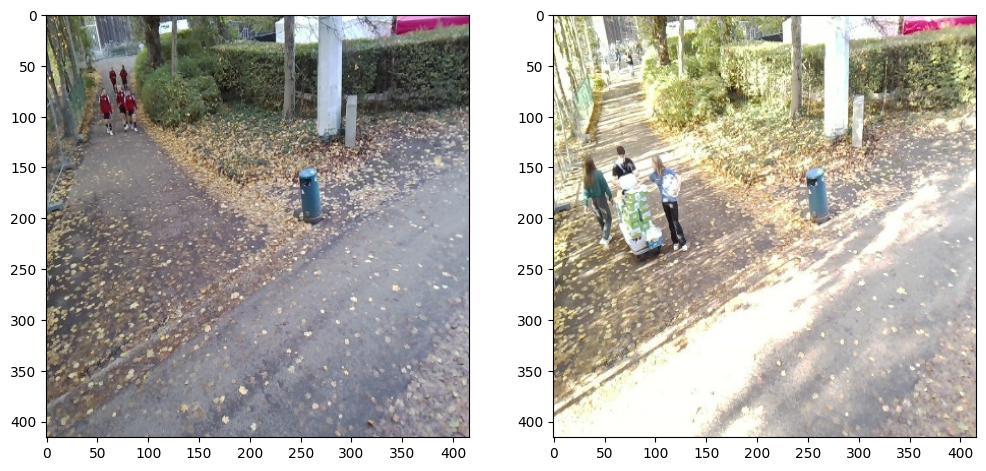

In [77]:
classes = open('coco.names').read().strip().split('\n')

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 12))
ax[0].imshow(images[6700])
ax[1].imshow(images[6505])

In [78]:
colors = np.random.randint(0, 255, size=(len(classes), 3), dtype='uint8') # Colors for our classes
net = cv.dnn.readNetFromDarknet('YOLO/yolov3.cfg', 'YOLO/yolov3.weights')
net.setPreferableBackend(cv.dnn.DNN_BACKEND_OPENCV)

In [79]:
blob = cv.dnn.blobFromImage(images[6505], 1/255.0, (416, 416), crop=False)
blob.shape

(1, 3, 416, 416)

In [84]:
ln = net.getLayerNames()
outNames = net.getUnconnectedOutLayersNames()


net.setInput(blob)
t0 = time.time()
outputs = net.forward(outNames)
t = time.time()
t - 10

1674297519.16315

In [85]:
outputs = np.vstack(outputs)

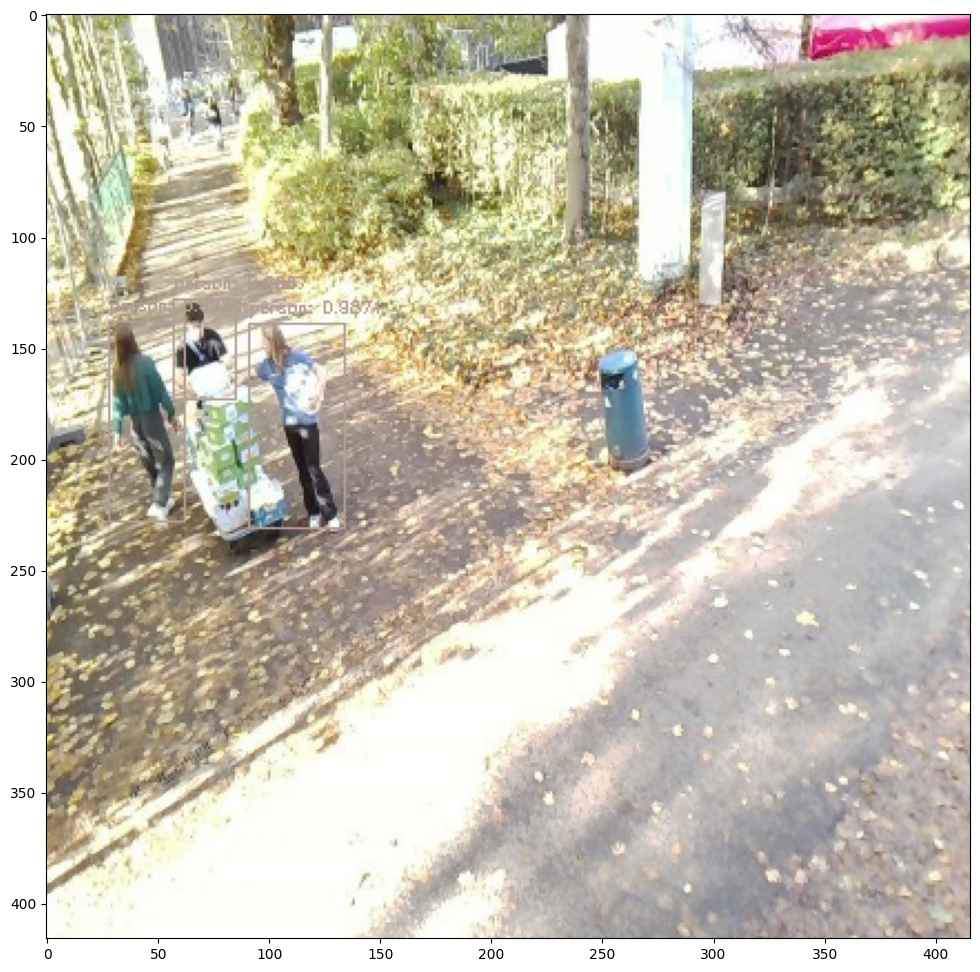

In [86]:
proximus = images[6505].copy()
boxes = []
confidences = []
classIDs = []
confTreshHold = 0.5
h, w = proximus.shape[:2]


for output in outputs:
        scores = output[5:]
        classID = np.argmax(scores)
        confidence = scores[classID]
        if confidence > confTreshHold:
            box = output[:4] * np.array([w, h, w, h])
            (centerX, centerY, width, height) = box.astype("int")
            x = int(centerX - (width / 2))
            y = int(centerY - (height / 2))
            box = [x, y, int(width), int(height)]
            boxes.append(box)
            confidences.append(float(confidence))
            classIDs.append(classID)

indices = cv.dnn.NMSBoxes(boxes, confidences, 0.5, 0.4)
if len(indices) > 0:
    for i in indices.flatten():
        (x, y) = (boxes[i][0], boxes[i][1])
        (w, h) = (boxes[i][2], boxes[i][3])
        color = [int(c) for c in colors[classIDs[i]]]
        cv.rectangle(proximus, (x, y), (x + w, y + h), color, 1)
        text = "{}: {:.4f}".format(classes[classIDs[i]], confidences[i])
        cv.putText(proximus, text, (x, y - 5), cv.FONT_HERSHEY_SIMPLEX, 0.25, color, 1)


fig, ax = plt.subplots(figsize=(12,12))
ax.imshow(proximus)

## Medium task

### Detailed comparison of fine-tuning versus from scratch (performance)

#### Fine-tuning

In [116]:
img_height = 416
img_width = 416
batch_size = 512

In [100]:
base_model = tf.keras.applications.Xception(weights="imagenet", include_top=False, input_shape=(img_height,img_width,3), pooling="max")

base_model.trainable = False

fine_tuning = tf.keras.Sequential([
    tf.keras.layers.Rescaling(scale=1 / 127.5, offset=-1),
    base_model,
    
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(5, activation='softmax')
])

In [102]:
fine_tuning.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss=tf.keras.losses.SparseCategoricalCrossentropy(), metrics=['accuracy'])

fine_tuning.build(input_shape=(None, img_height, img_width, 3))

fine_tuning.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_2 (Rescaling)     (None, 416, 416, 3)       0         
                                                                 
 xception (Functional)       (None, 2048)              20861480  
                                                                 
 dense_6 (Dense)             (None, 128)               262272    
                                                                 
 dense_7 (Dense)             (None, 32)                4128      
                                                                 
 dense_8 (Dense)             (None, 5)                 165       
                                                                 
Total params: 21,128,045
Trainable params: 266,565
Non-trainable params: 20,861,480
_________________________________________________________________


In [103]:
np_df = np.array(images2)

In [105]:
#check if there are nan values in the array
df['choice'].sort_values()

array([0, 1, 2], dtype=int64)

In [106]:
fine_tuning.fit(
    x = np_df,
    y = df['choice'],
    epochs=2,
)

Epoch 1/2
214/214 [==============================] - 870s 4s/step - loss: 0.8933 - accuracy: 0.5787
Epoch 2/2
214/214 [==============================] - 885s 4s/step - loss: 0.6994 - accuracy: 0.6745


#### From scratch

In [128]:
from_scratch = tf.keras.Sequential([
    tf.keras.layers.Rescaling(scale=1 / 127.5, offset=-1),

    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(),

    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(),

    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(),

    tf.keras.layers.Flatten(),
    
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(5, activation='softmax')
])

In [129]:
from_scratch.compile(
  optimizer=tf.keras.optimizers.Adam(learning_rate=3e-4),
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

from_scratch.build(input_shape=(None, img_height, img_width, 3))

from_scratch.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_13 (Rescaling)    (None, 416, 416, 3)       0         
                                                                 
 conv2d_103 (Conv2D)         (None, 414, 414, 32)      896       
                                                                 
 max_pooling2d_30 (MaxPoolin  (None, 207, 207, 32)     0         
 g2D)                                                            
                                                                 
 conv2d_104 (Conv2D)         (None, 205, 205, 32)      9248      
                                                                 
 conv2d_105 (Conv2D)         (None, 203, 203, 32)      9248      
                                                                 
 max_pooling2d_31 (MaxPoolin  (None, 101, 101, 32)     0         
 g2D)                                                

In [130]:
from_scratch.fit(
    x = np_df,
    y = df['choice'],
    epochs=2,
)

Epoch 1/2


C:\Users\jensg\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\backend.py:5585: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


214/214 [==============================] - 586s 3s/step - loss: 0.8359 - accuracy: 0.6340
Epoch 2/2
214/214 [==============================] - 589s 3s/step - loss: 0.5539 - accuracy: 0.7606


### Findings

Fine-tuning 2 epochs
- Duration: 29min 14.8s
- Epoch 1: 
  - Accuracy: 0.5787
  - Loss: 0.8933
- Epoch 2:
  - Accuracy: 0.6745
  - Loss: 0.6994

From scratch 2 epochs
- Duration: 19min 35.5s
- Epoch 1: 
  - Accuracy: 0.6340
  - Loss: 0.8359
- Epoch 2:
  - Accuracy: 0.7606
  - Loss: 0.5539

### Conclusion

From our findings, the model we trained from scratch performed better results (higher accuracy and lower loss) than the model we fine-tuned. <br>
It achieved these results 10 minutes faster than the model we fine-tuned.<br>
We can conclude that the model we trained ourselves from scratch performed better than the model we fine-tuned.

## Hard task